# PARC (Physics Aware Recurrent Convolutional Neural Network)

##### This notebook serves to demonstrate the capabilities of PARC and to gather the data necessary for training and making predictions on the data sets. The current setup receives microstructure image data and trains a neural network model based on the temperature and pressure fields in time. Training has also been tested on a shorter number of time steps than the data provided as well as only training with a singular field, and results have proved that PARC is able to accurately predict these cases.

## PARC Training with Temperature and Pressure Fields

### Load Libraries

In [2]:
import os
os.chdir("..")
from parc import model
from parc import IO
from parc import losses
from parc import graphs
import keras
import numpy as np

### Initialize Parameters

#### Input Data 

In [3]:
#initilizing input data characteristics
data_dir = "C:\\Users\\Austin Leonard\\parc_data\\data\\raw"  # input data file directory
case_numbers = 42  # number of cases
del_t = 0.79  # time step size (ns)
time_steps = 19  # number of time steps of data
t_idx = del_t * np.arange(1, time_steps + 1)  # creates time index in nanoseconds
threshold = 875  # temperature(K) at which a hotspot is detected
splits = [0.6, 0.2, 0.2]  # training/validation/test splits

#### Adaptable Model Parameters 

In [4]:
#initialize PARC model parameters
input_size = 240 #height/width size in pixels of the input image (using square image as input)
n_fields = 2 #number of fields testing at (ex. temperature/pressures/etc.)
numFeatureMaps = 128 #number of feature maps in the convolutional neural network

# initialize loss parameters
weight_loss = [4, 1, 1]  # initial timestep weights, middle weights, late weights
loss = "mse"
optimizer = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

### Data Initialization

#### Parse and Split Data 

In [ ]:
# Parse the raw data and return microstructure data, temperature/pressure outputs, initial values and normalizing constants
data_in, total_output, initial_vals, normalizing_constants = IO.parse_data(data_dir, time_steps, (del_t * (10**-9)))

In [ ]:
# Saves the parsed data as numpy arrays
np.save("output_data",total_output)
np.save("input_data",data_in)
np.save("initial_vals",initial_vals)
np.save("normalizing_constants.npy",normalizing_constants)

In [4]:
# Loads parsed data from file location (use if already have access to saved parsed data)
total_output = np.load("../parc_data/output_data.npy")
data_in = np.load("../parc_data/input_data.npy")
initial_vals = np.load("../parc_data/initial_vals.npy")
normalizing_constants = np.load("../parc_data/normalizing_constants.npy", allow_pickle=True)

In [5]:
# split data set into training, validation, and test splits
X_train,y_train,X_train_init,X_val,y_val,X_val_init,test_X,test_Y,test_X_init = IO.split_data(data_in, total_output, initial_vals, splits)

#### Prepare PARC

In [6]:
# initilize PARC neural network model
parc_model = model.PARC(input_size, n_fields, time_steps, numFeatureMaps)
parc_model.build()
parc_model.compile(loss=loss, optimizer=optimizer)

### Training

In [7]:
# reshape the data to fit training format
y_train = IO.reshape_old(y_train, n_fields)
y_val = IO.reshape_old(y_val, n_fields)
test_Y = IO.reshape_old(test_Y, n_fields)

Starting shape of data:  (25, 240, 240, 19, 4)
Reformatted data shape:  (25, 240, 240, 76)
Starting shape of data:  (8, 240, 240, 19, 4)
Reformatted data shape:  (8, 240, 240, 76)
Starting shape of data:  (8, 240, 240, 19, 4)
Reformatted data shape:  (8, 240, 240, 76)


In [ ]:
# train the model using training set
history = parc_model.fit(
    x=[X_train, X_train_init],
    y=[y_train[:, :, :, :(time_steps*n_fields)], y_train[:, :, :, (time_steps*n_fields):]],
    validation_data=([X_val, X_val_init], [y_val[:, :, :, :(time_steps*2)], y_val[:, :, :, (time_steps*2):]]),
    batch_size=1,
    epochs=500,
)

In [8]:
# save trained model weights
parc_model.save_weights("../parc_data/PARC_trained_data.h5")

In [8]:
# load trained model weights (use if already have access to trained weights)
parc_model.load_weights("../parc_data/preTrain.h5")

### Prediction

In [9]:
# creates a prediction based on trained model parameters
pred = parc_model.predict([test_X, test_X_init])

1/1 [==============================] - 342s 342s/step


In [10]:
# combines outputs and derivatives into one array
pred = np.concatenate((pred[0], pred[1]), axis=3)

# reshape data to fit into an easily accessible format
test_Y = IO.reshape_new(test_Y, n_fields)
pred = IO.reshape_new(pred, n_fields)

Starting shape of data:  (8, 240, 240, 76)
Reformatted data shape:  (8, 240, 240, 19, 4)
Starting shape of data:  (8, 240, 240, 76)
Reformatted data shape:  (8, 240, 240, 19, 4)


### Losses

In [11]:
# definition of temperature predictions and ground truth with rescaling
norm_T_min = normalizing_constants.item().get("Temperature").get("min")
norm_T_max = normalizing_constants.item().get("Temperature").get("max")
Temp_pred = pred[:, :, :, :, 0]
Temp_pred = IO.rescale(Temp_pred, norm_T_min, norm_T_max)
Temp_gt = test_Y[:, :, :, :, 0]
Temp_gt = IO.rescale(Temp_gt, norm_T_min, norm_T_max)

In [12]:
# definition of pressure predictions and ground truth with rescaling
norm_P_min = normalizing_constants.item().get("Pressure").get("min")
norm_P_max = normalizing_constants.item().get("Pressure").get("max")
Pres_pred = pred[:, :, :, :, 2]
Pres_pred = IO.rescale(Pres_pred, norm_P_min, norm_P_max)
Pres_gt = test_Y[:, :, :, :, 1]
Pres_gt = IO.rescale(Pres_gt, norm_P_min, norm_P_max)

In [13]:
# calculate root mean squared, r2 score, and losses for temperature (interchangable with pressure ground truth/predictions)
rmse = losses.rmse(Temp_gt, Temp_pred)
r2 = losses.r2(Temp_gt, Temp_pred)
loss_cv = losses.step_weighted_loss(Temp_gt, Temp_pred, weight_loss)
physical_loss = losses.step_weighted_physical_loss(Temp_gt, Temp_pred, loss_cv)
state_loss = losses.state_weighted_loss(test_Y, pred)

### Graphs

#### Temperature Prediction Visualization

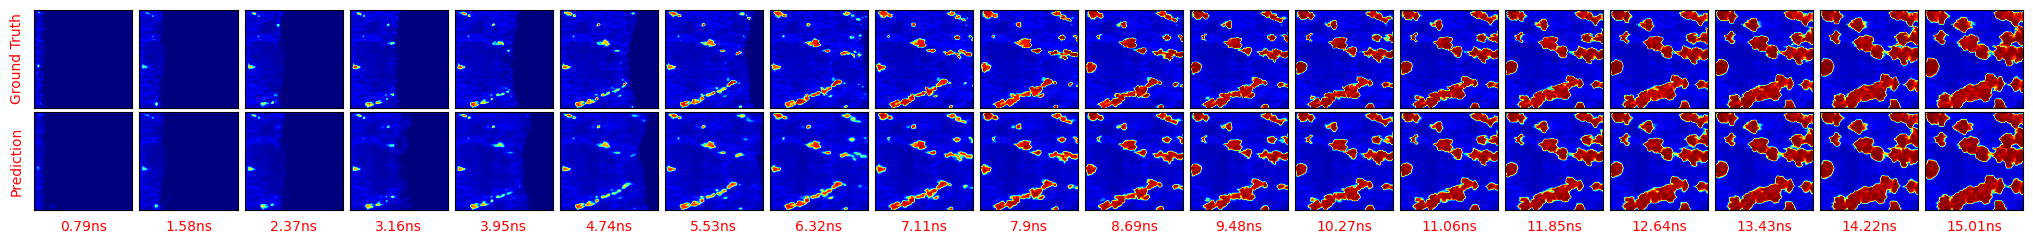

In [17]:
# Graph showing the temperature evolution in the microstructure
graphs.visualize_inference(Temp_gt, Temp_pred, t_idx, 0, norm_T_min, norm_T_max)

#### Pressure Prediction Visualization

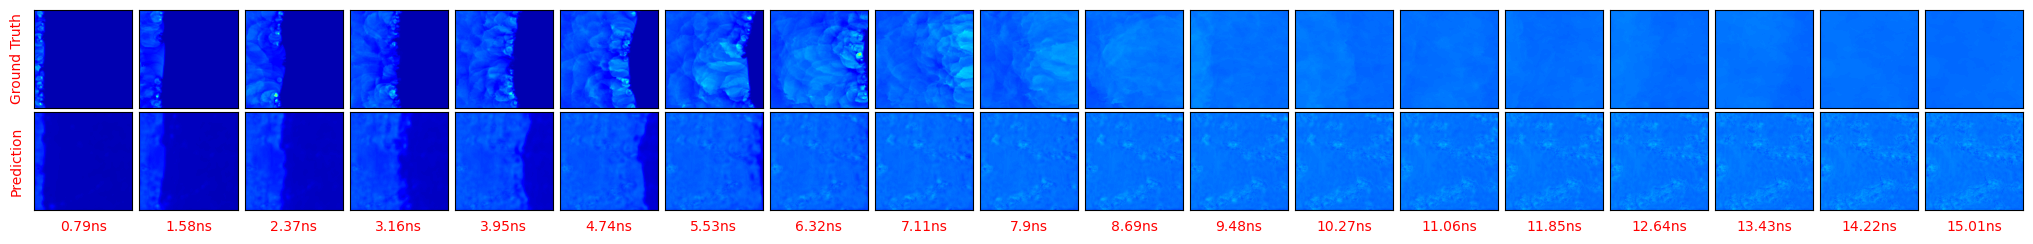

In [18]:
# Graph showing the pressure evolution in the microstructure
graphs.visualize_inference(Pres_gt, Pres_pred, t_idx, 0, norm_P_min, norm_P_max)

#### Root Mean Squared

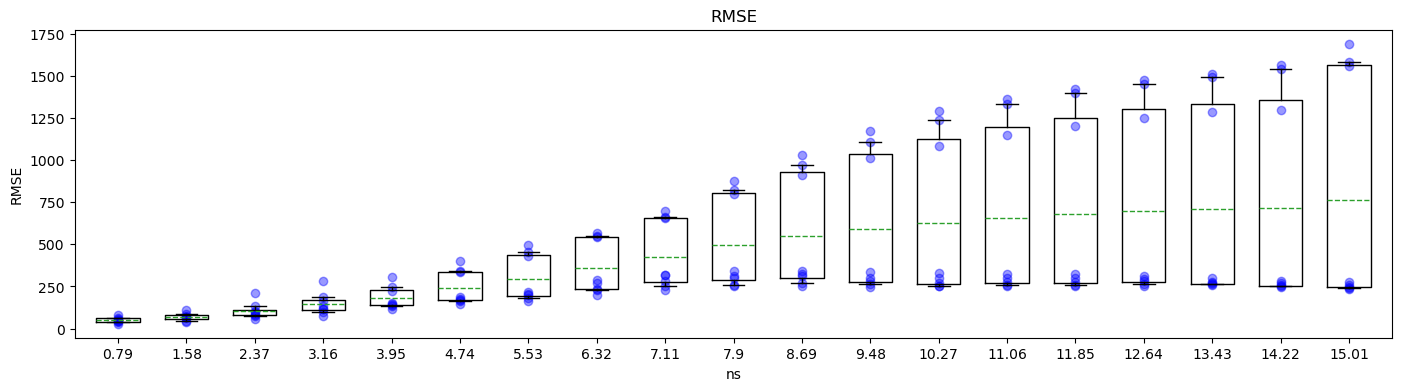

In [23]:
# Boxplot of the root mean squared values between ground truth and prediction temperature/pressure estimations for each time step
graphs.plot_rmse(rmse, t_idx)

#### R2 scores

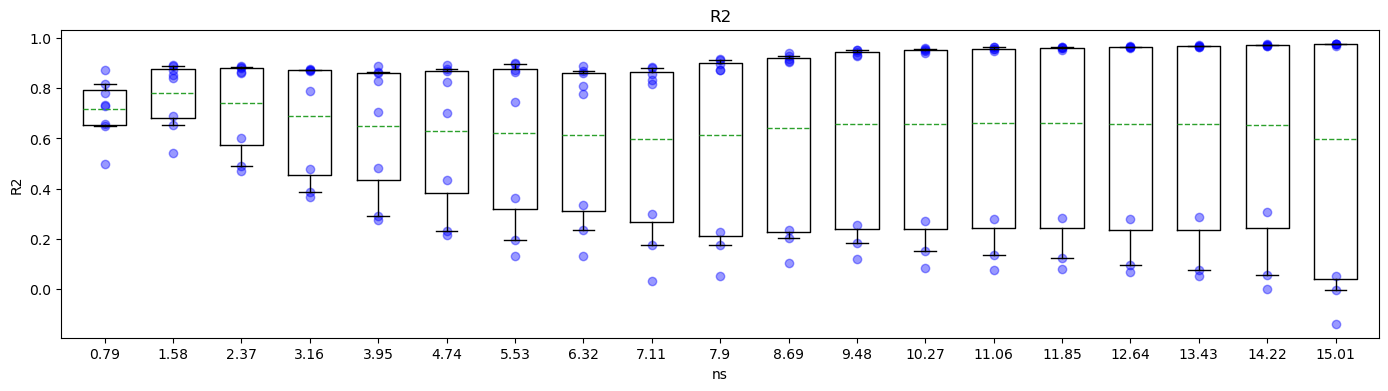

In [24]:
# Boxplot of the r2 scores between ground truth and prediction temperature/pressure estimations for each time step
graphs.plot_r2(r2, t_idx)

#### Hotspot Area Growth

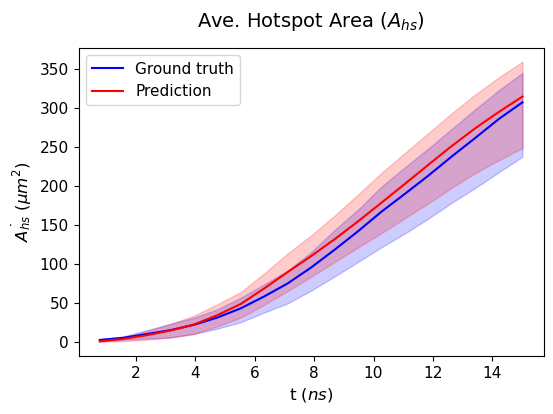

In [25]:
# Graph showing the growth in hotspot area over time for both ground truth/prediction values as well as 10th-90th percentile error estimation
graphs.plot_hotspot_area(Temp_gt, Temp_pred, t_idx, threshold)

#### Change in Hotspot Area Growth

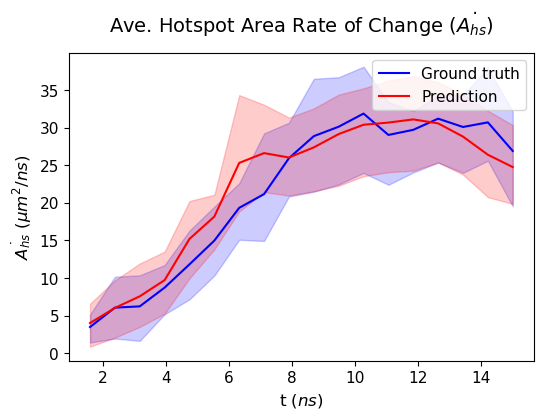

In [26]:
# Graph showing the rate of change in hotspot area over time for both ground truth/prediction values as well as 10th-90th percentile error estimation
graphs.plot_hotspot_area_dot(Temp_gt, Temp_pred, t_idx, threshold)

#### Hotspot Temperature

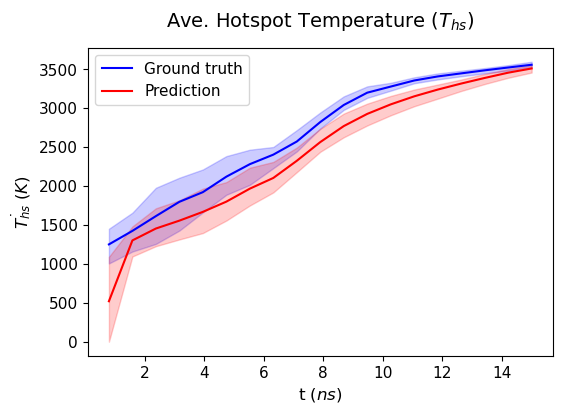

In [27]:
# Graph showing the growth in hotspot temperature over time for both ground truth/prediction values along with 10th-90th percentile error estimation
graphs.plot_hotspot_temperature(Temp_gt, Temp_pred, t_idx, threshold)

#### Change in Hotspot Temperature

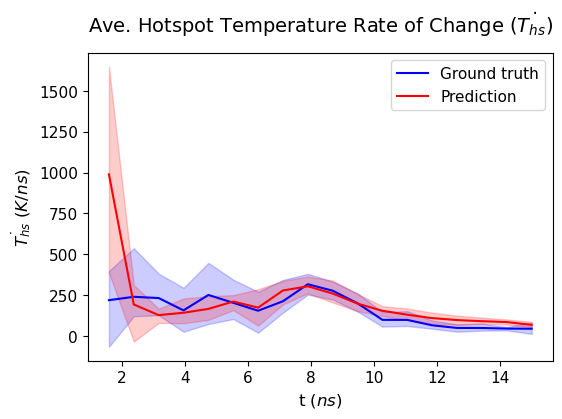

In [28]:
# Graph showing the rate of change in hotspot temperature over time for both ground truth/prediction values as well as 10th-90th percentile error estimation
graphs.plot_hotspot_temp_dot(Temp_gt, Temp_pred, t_idx, threshold)

#### Saliency Plot

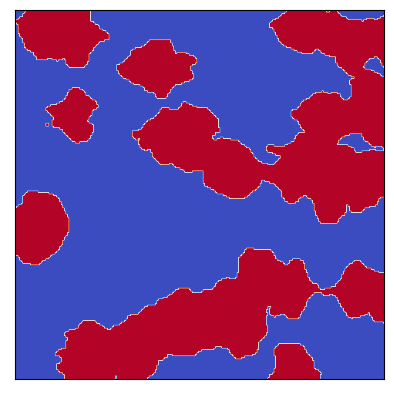

In [29]:
#Graph showing the origination of hotspots for the designated case and at the prescribed time step
case = 0
time_step = 17
graphs.plot_saliency(Temp_pred, case, time_step, threshold)

#### Visual animation of the Hotspot Temperature growth

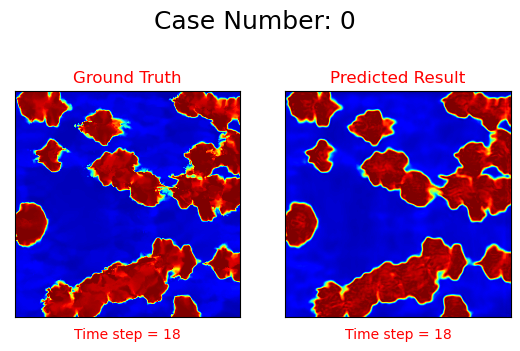

In [30]:
# Saves a video clip with the animated visualization of the growth of hotspot temperature/pressure
case = 0
graphs.animation_graph(Temp_gt, Temp_pred, case, norm_T_min, norm_T_max)

# Training with different parameters

###### Below shows two different ways in which the PARC model was tested and validated for different types of input data. The first test involved shortening the number of time steps that the model had access to, where the original data set had 19 time steps and the test case below only had 5. The second test involved only using the temperature data to train the model and excluding the pressure input data. The results showed that for both test cases, the model was still able to accurately predict the microstructure's reaction to shock just as well as the original case and this further validates the effectiveness of PARC.

## Shorter number of time steps

### Load Data

In [19]:
# Training data with shortened number of time steps
total_output = np.load("../parc_data/output_data_shorter_time.npy")
data_in = np.load("../parc_data/input_data_shorter_time.npy")
initial_vals = np.load("../parc_data/initial_vals_shorter_time.npy")
normalizing_constants_short = np.load("../parc_data/normalizing_constants_shorter_time.npy", allow_pickle=True)

In [20]:
# split data set into training, validation, and test splits
X_train_short,y_train_short,X_train_init_short,X_val_short,y_val_short,X_val_init_short,test_X_short,test_Y_short,test_X_init_short = IO.split_data(data_in, total_output, initial_vals, splits=[0.6, 0.2, 0.2])

### Model definition

In [25]:
# PARC test model w/ 2 fields and shortened timesteps (make sure to reload model module or error will result)
parc_model_short_time = model.PARC(240, 2, 5, 128)
parc_model_short_time.build()
parc_model_short_time.compile(loss=loss, optimizer=optimizer)

### Training

In [ ]:
# Training w/ 2 fields and shortened timesteps
history = parc_model_short_time.fit(
    x=[X_train_short, X_train_init_short],
    y=[y_train_short[:, :, :, : (5 * 2)], y_train_short[:, :, :, (5 * 2) :]],
    validation_data=(
        [X_val_short, X_val_init_short],
        [y_val_short[:, :, :, : (5 * 2)], y_val_short[:, :, :, (5 * 2) :]],
    ),
    batch_size=1,
    epochs=500,
)
parc_model_short_time.save_weights("../parc_data/shorttimeTrain.h5")

### Prediction

In [26]:
parc_model_short_time.load_weights("../parc_data/model_ts5_stateWeighted.h5")

# prediction for shortened timestep training
pred_short = parc_model_short_time.predict([test_X_short, test_X_init_short])

1/1 [==============================] - 94s 94s/step


In [29]:
# reshape data to fit into an easily accessible format
test_Y_short = IO.reshape_new(test_Y_short,2)
pred_short = np.concatenate((pred_short[0],pred_short[1]),axis=3)
pred_short = IO.reshape_new(pred_short,2)

Starting shape of data:  (8, 240, 240, 20)
Reformatted data shape:  (8, 240, 240, 5, 4)


### Graphs

In [31]:
# definition of temperature predictions and ground truth with rescaling
norm_T_min = normalizing_constants_short.item().get("Temperature").get("min")
norm_T_max = normalizing_constants_short.item().get("Temperature").get("max")
Temp_pred_short = pred_short[:, :, :, :, 0]
Temp_pred_short = IO.rescale(Temp_pred_short, norm_T_min, norm_T_max)
Temp_gt_short = test_Y_short[:, :, :, :, 0]
Temp_gt_short = IO.rescale(Temp_gt_short, norm_T_min, norm_T_max)

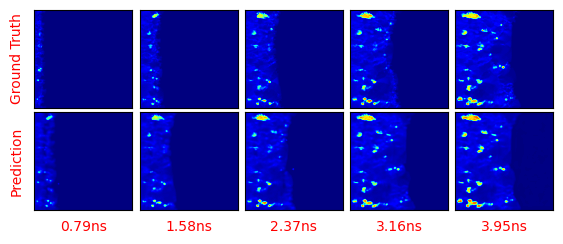

In [33]:
# Graph showing the temperature evolution in the microstructure for the shortened time steps
graphs.visualize_inference(Temp_gt_short, Temp_pred_short, t_idx[:5], 2, norm_T_min, norm_T_max)

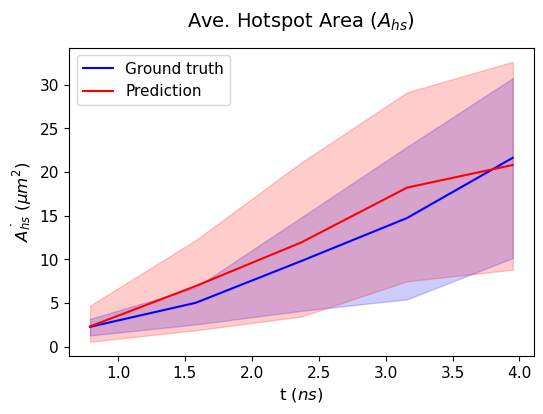

In [36]:
# Graph showing the growth in hotspot area over time for both ground truth/prediction values w/ error for shortened time
graphs.plot_hotspot_area(Temp_gt_short, Temp_pred_short, t_idx[:5], threshold)

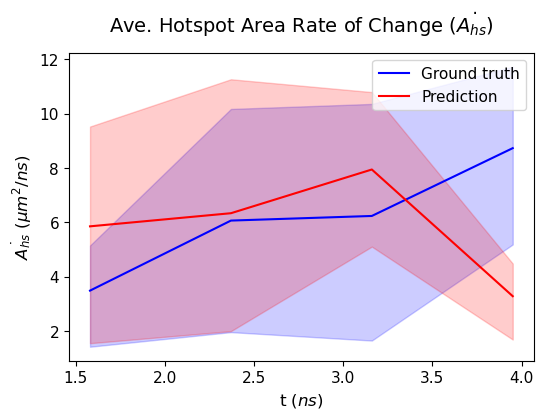

In [38]:
# Graph showing the rate of change in hotspot area over time for both ground truth/prediction values w/ error for shortened time steps
graphs.plot_hotspot_area_dot(Temp_gt_short, Temp_pred_short, t_idx[:5], threshold)

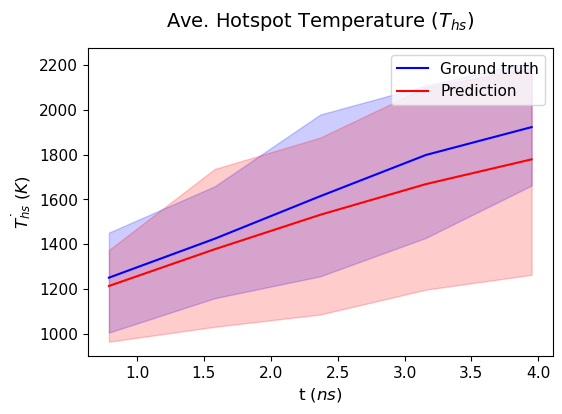

In [39]:
# Graph showing the growth in hotspot temperature over time for both ground truth/prediction values w/ error for shortened time steps
graphs.plot_hotspot_temperature(Temp_gt_short, Temp_pred_short, t_idx[:5], threshold)

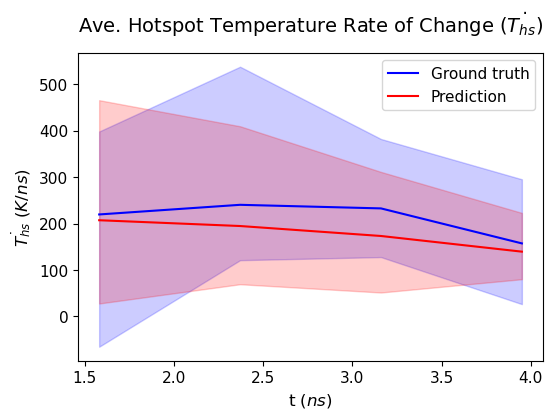

In [40]:
# Graph showing the rate of change in hotspot temperature over time for both ground truth/prediction values w/ error for shortened time steps
graphs.plot_hotspot_temp_dot(Temp_gt_short, Temp_pred_short, t_idx[:5], threshold)

## Single Field Training 

### Load Data

In [5]:
# Training data with only temperature field data as input
total_output = np.load("../parc_data/output_data_temp_field.npy")
data_in = np.load("../parc_data/input_data_temp_field.npy")
initial_vals = np.load("../parc_data/initial_vals_temp_field.npy")
normalizing_constants_single = np.load("../parc_data/normalizing_constants_temp_field.npy", allow_pickle=True)

# split data set
X_train_single,y_train_single,X_train_init_single,X_val_single,y_val_single,X_val_init_single,test_X_single,test_Y_single,test_X_init_single = IO.split_data(data_in, total_output, initial_vals, splits=[0.6, 0.2, 0.2])
test_X_init_single = test_X_init_single[:,:,:,np.newaxis]

### Model definition

In [6]:
# Test model w/ 1 field and full timesteps
parc_model_single_field = model.PARC(240, 1, 19, 128)
parc_model_single_field.build()
parc_model_single_field.compile(loss=loss, optimizer=optimizer)

### Training

In [ ]:
# Training w/ 1 field and full timesteps
history = parc_model_single_field.fit(
    x=[X_train_single, X_train_init_single],
    y=[y_train_single[:, :, :, :19], y_train_single[:, :, :, 19:]],
    validation_data=(
        [X_val_single, X_val_init_single],
        [y_val_single[:, :, :, :(time_steps)], y_val_single[:, :, :, (time_steps):]],
    ),
    batch_size=1,
    epochs=500,
)
parc_model_single_field.save_weights("../parc_data/singlefieldTrain.h5")

### Prediction

In [7]:
parc_model_single_field.load_weights("../parc_data/field1.h5")

# prediction for single field training
pred_single = parc_model_single_field.predict([test_X_single, test_X_init_single])

1/1 [==============================] - 330s 330s/step


In [8]:
#reshape to match new data format
test_Y_single = IO.reshape_new(test_Y_single,1)
pred_single = np.concatenate((pred_single[0],pred_single[1]),axis=3)
pred_single = IO.reshape_new(pred_single,1)

Starting shape of data:  (8, 240, 240, 38)
Reformatted data shape:  (8, 240, 240, 19, 2)
Starting shape of data:  (8, 240, 240, 38)
Reformatted data shape:  (8, 240, 240, 19, 2)


### Graphs

In [9]:
# single field
norm_T_min = normalizing_constants_single.item().get("Temperature").get("min")
norm_T_max = normalizing_constants_single.item().get("Temperature").get("max")
Temp_pred_single = pred_single[:, :, :, :, 0]
Temp_pred_single = IO.rescale(Temp_pred_single, norm_T_min, norm_T_max)
Temp_gt_single = test_Y_single[:, :, :, :, 0]
Temp_gt_single = IO.rescale(Temp_gt_single, norm_T_min, norm_T_max)

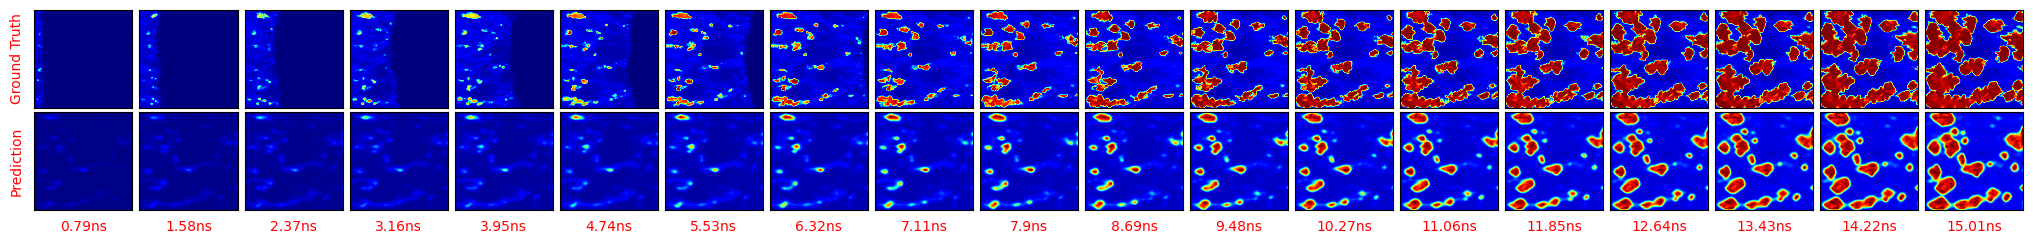

In [10]:
# Graph showing the temperature evolution in the microstructure for the single field training
graphs.visualize_inference(Temp_gt_single, Temp_pred_single, t_idx, 2, norm_T_min, norm_T_max)

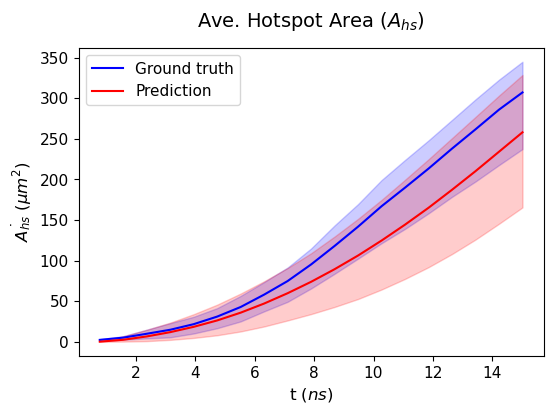

In [55]:
# Graph showing the growth in hotspot area over time for both ground truth/prediction values w/ error for single field
graphs.plot_hotspot_area(Temp_gt_single, Temp_pred_single, t_idx, threshold)

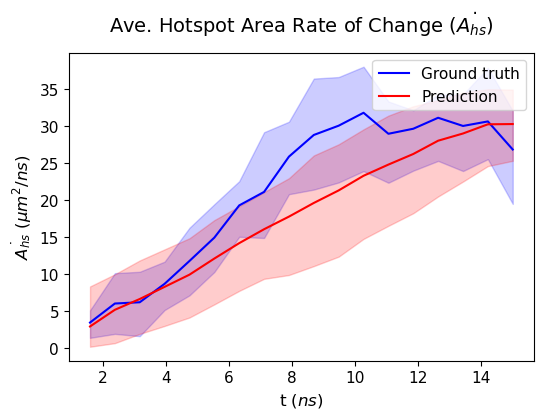

In [56]:
# Graph showing the rate of change in hotspot area over time for both ground truth/prediction values w/ error for single field
graphs.plot_hotspot_area_dot(Temp_gt_single, Temp_pred_single, t_idx, threshold)

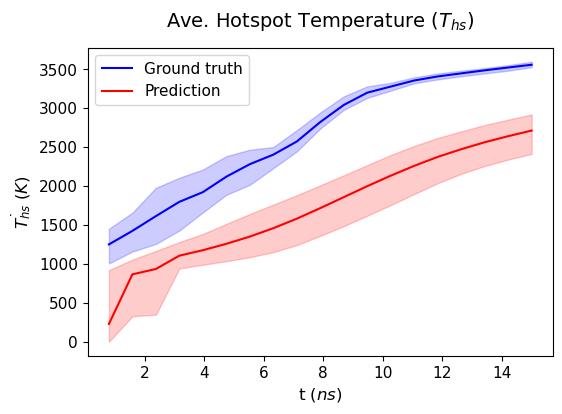

In [57]:
# Graph showing the growth in hotspot temperature over time for both ground truth/prediction values w/ error for single field
graphs.plot_hotspot_temperature(Temp_gt_single, Temp_pred_single, t_idx, threshold)

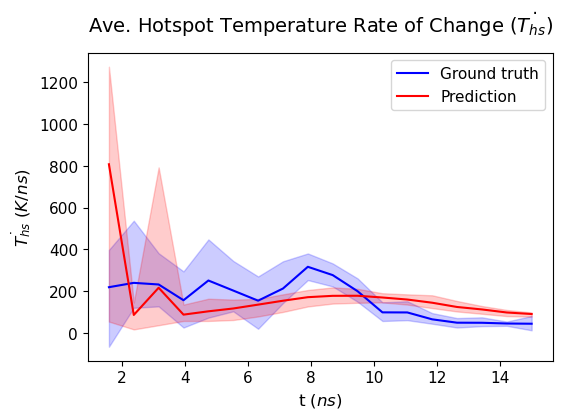

In [59]:
# Graph showing the rate of change in hotspot temperature over time for both ground truth/prediction values w/ error for single field
graphs.plot_hotspot_temp_dot(Temp_gt_single, Temp_pred_single, t_idx, threshold)